In [ ]:
# install dependencies
!pip install -q tensorflow-datasets
!pip install -q keras-vis
!pip install -q tf-keras-vis tensorflow
!pip install -q ipywidgets

In [ ]:
# import libraries -- not all of them ended up being used
import tensorflow as tf # for machine learning stuff
import tensorflow_datasets as tfds # for built in datasets

import pandas as pd # for linear algebra computations
import numpy as np # for reading and writing data

import os # to interact with the operating system
from os import listdir # to get entries in a directory

import matplotlib.pyplot as plt # to display images
from sklearn import metrics # for assessing prediction error

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# can probably change the transfer learning method here
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#from vis.utils import utils -- deprecated
from collections.abc import Iterable

from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

import json

# for the slider functionality
import ipywidgets as widgets
from IPython.display import display

# for getting and processing online images
import requests
from io import BytesIO
from PIL import Image

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# weights can be either None, 'imagenet' or file path to saved weights
model = Model(weights="imagenet", include_top=True)

# change url to point to desired image -- this is not the case on webapp version
url = 'https://media.istockphoto.com/id/533861572/photo/football-in-the-sunset.webp?s=2048x2048&w=is&k=20&c=ub56conpB8wD11gKwdqiD-0stkn64tnsK2xGikq8Ndc='
response = requests.get(url)
img1 = Image.open(BytesIO(response.content))
img1 = img1.resize((224, 224))

# can also change to use locally saved image
# img1 = load_img('images/violin.jpeg', target_size=(224, 224))

# convert a copy of img1 to numpy array for reshaping
img1_c = img_to_array(img1)

# reshape to prepare for processing
img1_c = img1_c.reshape(1, 224, 224, 3)

# preprocess to prepare for input
img1_c = preprocess_input(img1_c)

# predicting the image
yhat1 = model.predict(img1_c)

# decoding the prediction
label1 = decode_predictions(yhat1)

# extracts top predictions for input
label1 = label1[0][0]
# prediction with X% confidence
#display(img1), label1[1], label1[2] * 100

import requests

url = "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"
r = requests.get(url)

# opens file to write as binary
with open("imagenet_class_index.json", "wb") as f:
    f.write(r.content)

# prepare 1000 classes
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
#print("N of class={}".format(len(classlabel)))

# predicts top X classes predicted
class_idxs_sorted1 = np.argsort(yhat1.flatten())[::-1]
X = 5

for i, idx in enumerate(class_idxs_sorted1[:X]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,yhat1[0,idx]))

    # stores index and classification of highest prediction
    if i == 0:
        highest_pred_idx = idx
        highest_pred_label = classlabel[idx]

35363/35363 [==============================] - 0s 0us/step
Top 1 predicted class:     Pr(Class=soccer_ball        [index=805])=0.999
Top 2 predicted class:     Pr(Class=golf_ball          [index=574])=0.001
Top 3 predicted class:     Pr(Class=rugby_ball         [index=768])=0.000
Top 4 predicted class:     Pr(Class=football_helmet    [index=560])=0.000
Top 5 predicted class:     Pr(Class=volleyball         [index=890])=0.000


## Grad-Cam

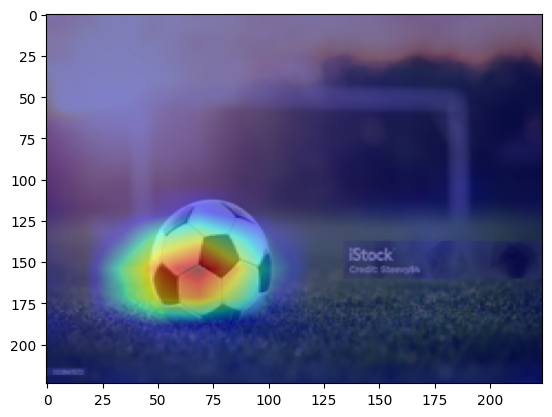

In [ ]:
score = CategoricalScore([highest_pred_idx])

# modify to add more images
images = np.asarray([np.array(img1)])
input_classes = [highest_pred_label]
input_images = preprocess_input(images)

# creates Gradcam object
gradcam = Gradcam(model,
                  clone=True)

# generates heatmap with GradCAM
cam = gradcam(score,
              input_images,
              penultimate_layer=-1)

# plots original image with heatmap overlayed
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(images[0], aspect='auto')
plt.imshow(heatmap, cmap='jet', alpha=0.5, aspect='auto')
plt.show()

In [ ]:
# defines function to update plot based on the slider value
def update_plot(percentage_importance):
    threshold_value = np.percentile(cam[0], 100-percentage_importance)
    mask = cam[0] > threshold_value
    mask3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

    # reconstructed image
    importance_image = images[0] * mask3d

    # importance regions image
    importance_regions = np.zeros_like(cam[0])
    importance_regions[mask] = cam[0][mask]

    # to fit 2 different images
    fig, axs = plt.subplots(1, 2)

    fig.suptitle(f"image reconstructed with {percentage_importance}% most important features")

    axs[0].imshow(importance_image)
    axs[1].imshow(importance_regions)
    plt.show()

# creates slider object
percentage_slider = widgets.IntSlider(
    value=10, # initial value
    min=0,
    max=100,
    step=1,
    description="Importance",
    continuous_update=False) # only updates plot when slider is released

interactive_plot = widgets.interactive(update_plot, percentage_importance=percentage_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Importance'), Output()), _dom_…